# Udacity - Write a Data Science blog

Project for the Udacity nanodegree of [Data Science for Scientists](https://learn.udacity.com/nanodegrees/nd001-ibm-datascience).

This notebook contains the code for my data science blog on [Medium](). I chose the StackOverflow data for the last 5 years: 2023-2019. Please see the [README.md] file for the descriptions.

## Libraries and global variables

In [364]:
import os
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import numpy as np

years = list(range(2023, 2018, -1))

## Download the data

In [365]:
baseurl = "https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/"
baseurl_2023 = "https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/"
data_folder = "data"
os.makedirs(data_folder, exist_ok=True)

for year in years:
    filename = "stack-overflow-developer-survey-%d.zip" % year
    outfile = os.path.join(data_folder, filename)
    if not os.path.isfile(outfile):
        if year == 2023:
            url = baseurl_2023 + filename
        else:
            url = baseurl + filename
        
        print("Downloading:", year, url)
        urllib.request.urlretrieve(url, outfile)
    else:
        print("File exists:", year, outfile)

    with zipfile.ZipFile(outfile, 'r') as zip_ref:
        unzip_folder = os.path.join(data_folder, os.path.splitext(filename)[0])
        os.makedirs(unzip_folder, exist_ok=True)
        print("Extracting to:", unzip_folder)
        zip_ref.extractall(unzip_folder)

File exists: 2023 data/stack-overflow-developer-survey-2023.zip
Extracting to: data/stack-overflow-developer-survey-2023
File exists: 2022 data/stack-overflow-developer-survey-2022.zip
Extracting to: data/stack-overflow-developer-survey-2022
File exists: 2021 data/stack-overflow-developer-survey-2021.zip
Extracting to: data/stack-overflow-developer-survey-2021
File exists: 2020 data/stack-overflow-developer-survey-2020.zip
Extracting to: data/stack-overflow-developer-survey-2020
File exists: 2019 data/stack-overflow-developer-survey-2019.zip
Extracting to: data/stack-overflow-developer-survey-2019


## Loading the data

In [366]:
survey_results_file = "survey_results_public.csv"
#survey_results_schema = "survey_results_schema.csv"

# Store the surveys for each year.
surveys = {}

for year in years:
    filename = "stack-overflow-developer-survey-%d.zip" % year
    unzip_folder = os.path.join(data_folder, os.path.splitext(filename)[0])
    survey_filepath = os.path.join(unzip_folder, survey_results_file)
    #schema_filepath = os.path.join(unzip_folder, survey_results_schema)

    print("Loading:", survey_filepath)
    survey = pd.read_csv(survey_filepath)
    #schema = pd.read_csv(schema_filepath)

    surveys[year] = survey

Loading: data/stack-overflow-developer-survey-2023/survey_results_public.csv
Loading: data/stack-overflow-developer-survey-2022/survey_results_public.csv
Loading: data/stack-overflow-developer-survey-2021/survey_results_public.csv
Loading: data/stack-overflow-developer-survey-2020/survey_results_public.csv
Loading: data/stack-overflow-developer-survey-2019/survey_results_public.csv


## Assess the data

In [367]:
for year in years:
    df = surveys[year]
    print(year)
    df.info()

2023
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode              

In [368]:
for year in years:
    df = surveys[year]
    print(year)
    print(df.describe())

2023
         ResponseId     CompTotal       WorkExp  ConvertedCompYearly
count  89184.000000  4.822500e+04  43579.000000         4.801900e+04
mean   44592.500000  1.036807e+42     11.405126         1.031101e+05
std    25745.347541  2.276847e+44      9.051989         6.814188e+05
min        1.000000  0.000000e+00      0.000000         1.000000e+00
25%    22296.750000  6.300000e+04      5.000000         4.390700e+04
50%    44592.500000  1.150000e+05      9.000000         7.496300e+04
75%    66888.250000  2.300000e+05     16.000000         1.216410e+05
max    89184.000000  5.000000e+46     50.000000         7.435143e+07
2022
         ResponseId     CompTotal  VCHostingPersonal use  \
count  73268.000000  3.842200e+04                    0.0   
mean   36634.500000  2.342434e+52                    NaN   
std    21150.794099  4.591478e+54                    NaN   
min        1.000000  0.000000e+00                    NaN   
25%    18317.750000  3.000000e+04                    NaN   
50%    36

## Feature selection

We select the features needed to answer our business questions.

In [369]:
# 2020 and earlier had some different column names.
rename_cols = {
    "LanguageWorkedWith": "LanguageHaveWorkedWith",
    "ConvertedComp": "ConvertedCompYearly"
}

# Inconsistent naming
rename_vals = {
    "United States": "USA",
    "United States of America": "USA",
    "Less than 1 year": "0",
    "More than 50 years": "51"
}

# Selected fetaures for analysis
features = {
    "MainBranch": [],
    "Age": [],
    "Employment": [],
    #"RemoteWork": [], # not in 2021 and earlier surveys
    "YearsCodePro": [],
    "DevType": [],
    "OrgSize": [],
    "Country": ["Australia", "USA"],
    "LanguageHaveWorkedWith": [],
    #"AISearchHaveWorkedWith": [], # not in 2022 and earlier surveys
    #"AIDevHaveWorkedWith": [], # not in 2022 and earlier surveys
    #"Industry": [], # not in 2022 and earlier surveys
    "ConvertedCompYearly": []    
}

surveys_filtered = {}

for year in years:
    df = surveys[year].copy()

    # Normalize columns and values
    df = df.rename(columns=rename_cols)
    df["Country"] = df["Country"].replace(rename_vals)
    df["YearsCodePro"] = df["YearsCodePro"].replace(rename_vals).fillna("-1").astype(int)

    # Select only the features we want
    df = df[features.keys()]

    for feature_name, feature_values in features.items():
        if len(feature_values) > 0:
            df = df.loc[df[feature_name].isin(feature_values)]
    surveys_filtered[year] = df

    # Check values
    print(year)
    print(df["Country"].unique())
    print(df["YearsCodePro"].unique())
    print(df.head())

2023
['USA' 'Australia']
[ 9 23  7  3  0 19 15 16  2 -1 30 32 24 10 12  6 20 18 25 27 43 33 44 29
  5 22 11  4 14 13 28  8 40 42 17 21 26 31 51  1 36 39 35 38 41 34 50 48
 37 46 45 47 49]
                       MainBranch              Age           Employment  \
1  I am a developer by profession  25-34 years old  Employed, full-time   
2  I am a developer by profession  45-54 years old  Employed, full-time   
3  I am a developer by profession  25-34 years old  Employed, full-time   
6  I am a developer by profession  35-44 years old  Employed, full-time   
7  I am a developer by profession  25-34 years old  Employed, full-time   

   YearsCodePro                               DevType  \
1             9  Senior Executive (C-Suite, VP, etc.)   
2            23                   Developer, back-end   
3             7                  Developer, front-end   
6             3                 Developer, full-stack   
7             3                 Developer, full-stack   

                  

## Question 1 - Which country has the highest compensation over the last 5 years?

In [370]:
dfs = []

# Compute the median compensation
for year in reversed(years):
    df = surveys_filtered[year].copy()
    medians = df[["Country", "ConvertedCompYearly"]].groupby(["Country"]).median().reset_index()
    medians["Year"] = year

    dfs.append(medians)
df_medians = pd.concat(dfs)
print(df_medians)

# Pivot the data for plotting
df_comps = pd.pivot_table(df_medians, values="ConvertedCompYearly", index="Year", columns="Country")
print(df_comps)


     Country  ConvertedCompYearly  Year
0  Australia              79783.0  2019
1        USA             110000.0  2019
0  Australia              76831.0  2020
1        USA             115000.0  2020
0  Australia              80172.0  2021
1        USA             125000.0  2021
0  Australia              93772.0  2022
1        USA             145000.0  2022
0  Australia              95851.0  2023
1        USA             150000.0  2023
Country  Australia       USA
Year                        
2019       79783.0  110000.0
2020       76831.0  115000.0
2021       80172.0  125000.0
2022       93772.0  145000.0
2023       95851.0  150000.0


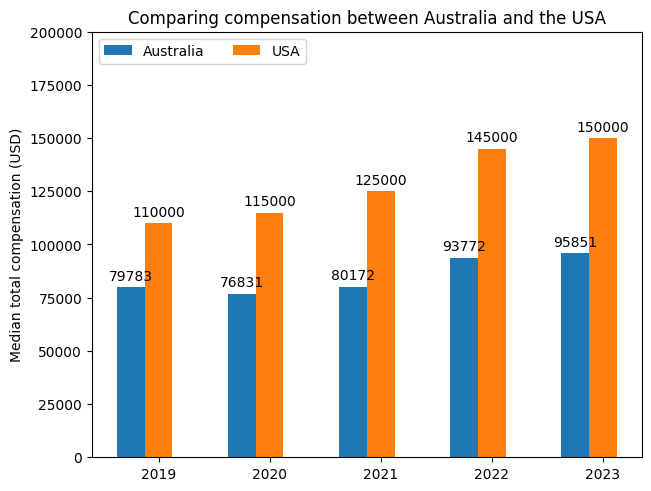

In [371]:
# Adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#grouped-bar-chart-with-labels

comps = {}

for country in features["Country"]:
    comps[country] = list(df_comps[country].values)

x = np.arange(len(years))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for country, median_comp in comps.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, median_comp, width, label=country)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median total compensation (USD)')
ax.set_title('Comparing compensation between Australia and the USA')
ax.set_xticks(x + width, reversed(years))
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 200000)

plt.savefig("question1.png")
plt.show()


## Question 2 - What was the compensation growth based on professional experience in the last 5 years?

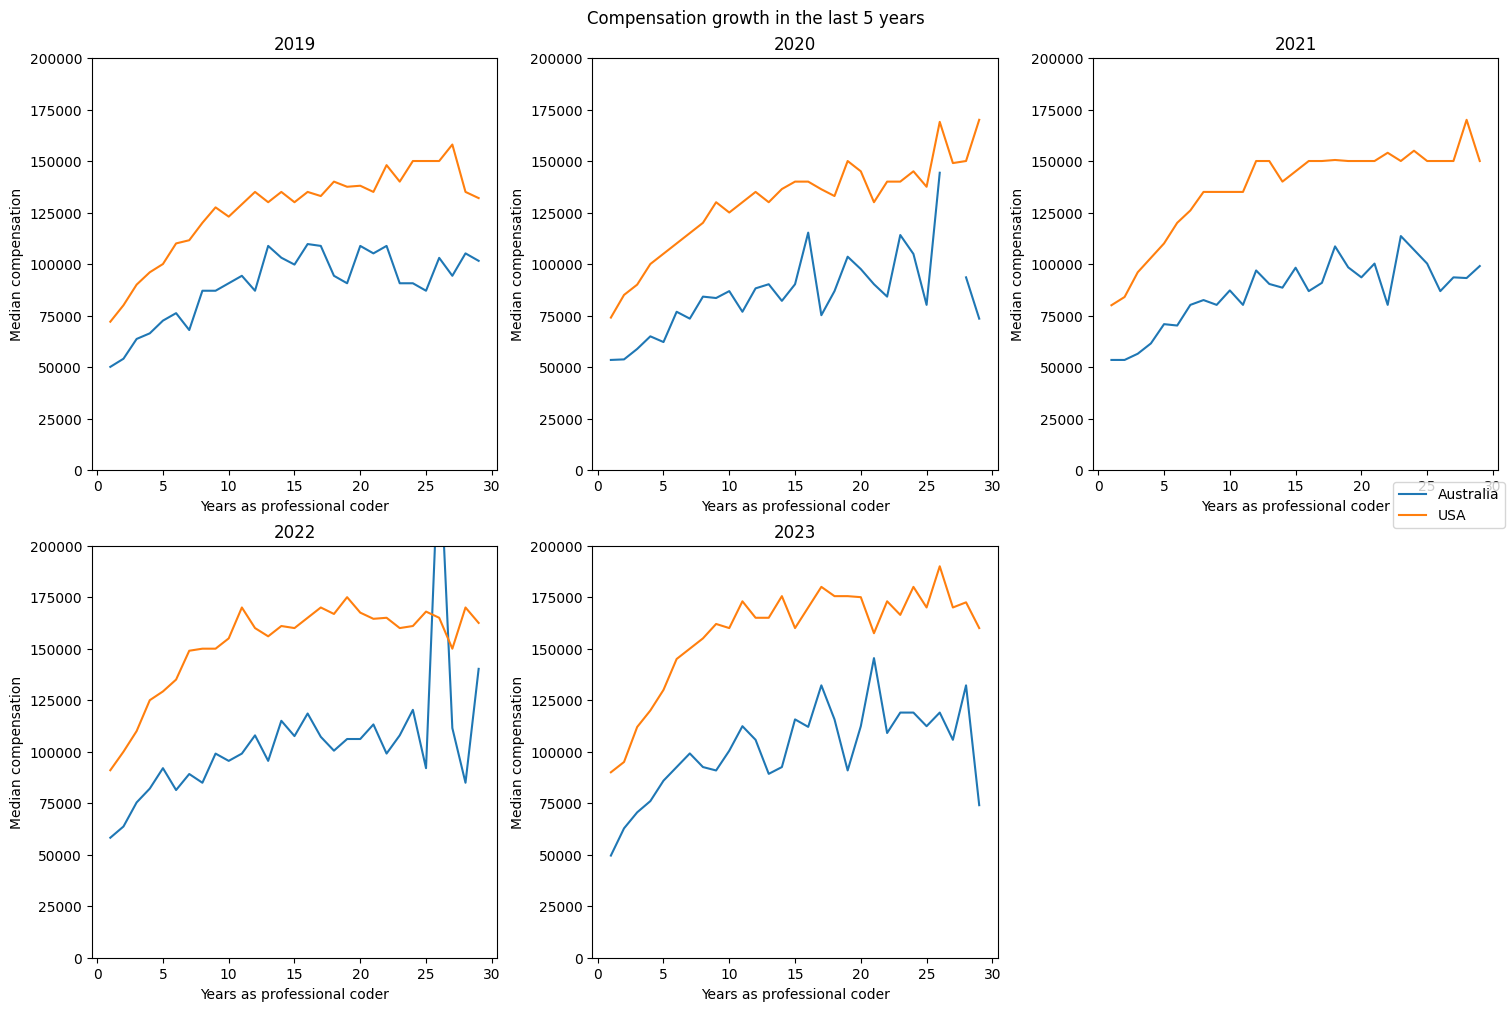

In [372]:
# Adapted from https://stackoverflow.com/a/72892852
# and https://stackoverflow.com/a/56724332

ncols = 3
nrows = 2

dfs = []
# Compute the median compensation
for year in reversed(years):
    df = surveys_filtered[year].copy()
    medians = df[["Country", "YearsCodePro", "ConvertedCompYearly"]].groupby(["Country", "YearsCodePro"]).median().reset_index()
    #print(medians)

    # Pivot the data for plotting
    df_comps = pd.pivot_table(medians, values="ConvertedCompYearly", index=["YearsCodePro"], columns=["Country"]).reset_index()
    df_comps = df_comps.sort_values(by=["YearsCodePro"])
    df_comps = df_comps[(df_comps["YearsCodePro"] > 0) & (df_comps["YearsCodePro"] < 30)]
    df_comps = df_comps.set_index("YearsCodePro")
    #print(df_comps)

    dfs.append(df_comps)
    
    #df_comps.plot()
    #plt.xlabel("Number of years as coding professional")
    #plt.ylabel("Median compensation (USD)")
    #plt.title("Median compensation growth")
    #plt.show()

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10), constrained_layout=True)

# plot counter
count = 0
for r in range(nrows):
    for c in range(ncols):
        ax = dfs[count].plot(ax=axes[r,c])
        ax.set_title(list(reversed(years))[count])
        ax.set_xlabel("Years as professional coder")
        ax.set_ylabel("Median compensation")
        ax.get_legend().remove()
        ax.set_ylim(0, 200000)
        count+=1
        if count >= len(dfs):
            break
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

axes[nrows-1, ncols-1].set_visible(False)

fig.suptitle('Compensation growth in the last 5 years')

plt.savefig("question2.png")
plt.show()


## Question 3 - Which programming languages have had the most positive change in the last 5 years, in Australia and the USA ?

In [373]:
# Adapted from https://stackoverflow.com/a/72892852
# and https://stackoverflow.com/a/56724332

ncols = 3
nrows = 2

dfs = []
# Compute the median compensation
for year in reversed(years):
    df = surveys_filtered[year].copy()
    df = df[["Country", "LanguageHaveWorkedWith"]].dropna()
    df["LanguageHaveWorkedWith"] = df["LanguageHaveWorkedWith"].apply(lambda row: row.split(";"))

    df = df.explode(["LanguageHaveWorkedWith"])
    df = df.value_counts().reset_index()
    df["Year"] = year

    dfs.append(df)

df_langs = pd.concat(dfs)

# Drop shell languages
df_langs = df_langs[~df_langs["LanguageHaveWorkedWith"].str.lower().str.contains("shell")]
print(df_langs)

       Country LanguageHaveWorkedWith  count  Year
0          USA             JavaScript  14672  2019
1          USA               HTML/CSS  13488  2019
2          USA                    SQL  11829  2019
3          USA                 Python  10083  2019
5          USA                   Java   7608  2019
..         ...                    ...    ...   ...
97   Australia                    Nim      8  2023
98   Australia                  OCaml      8  2023
99   Australia                   Flow      7  2023
100  Australia                  Cobol      7  2023
101  Australia                   Raku      1  2023

[352 rows x 4 columns]


In [374]:
# Pivot to filter out values
df_pivot = pd.pivot_table(df_langs, values="count", index=["Country", "LanguageHaveWorkedWith"], columns="Year").reset_index()
df_pivot = df_pivot.sort_values(by=2023, ascending=False)

df_10 = df_pivot.groupby("Country").head(10)
print(df_10)

Year    Country LanguageHaveWorkedWith     2019    2020    2021    2022  \
79          USA             JavaScript  14672.0  8156.0  9987.0  9018.0   
95          USA                 Python  10083.0  5964.0  7975.0  7017.0   
76          USA               HTML/CSS  13488.0  7429.0  8492.0  7369.0   
101         USA                    SQL  11829.0  6673.0  7332.0  6975.0   
105         USA             TypeScript   4568.0  3082.0  4701.0  4818.0   
60          USA                     C#   6781.0  3881.0  4497.0  4064.0   
78          USA                   Java   7608.0  4127.0  4688.0  4073.0   
61          USA                    C++   4554.0  2578.0  3443.0  3000.0   
59          USA                      C   3684.0  2190.0  2870.0  2394.0   
99          USA                   Rust    879.0   869.0  1584.0  1691.0   
24    Australia             JavaScript   1365.0   800.0  1110.0   979.0   
21    Australia               HTML/CSS   1236.0   730.0   927.0   815.0   
46    Australia          

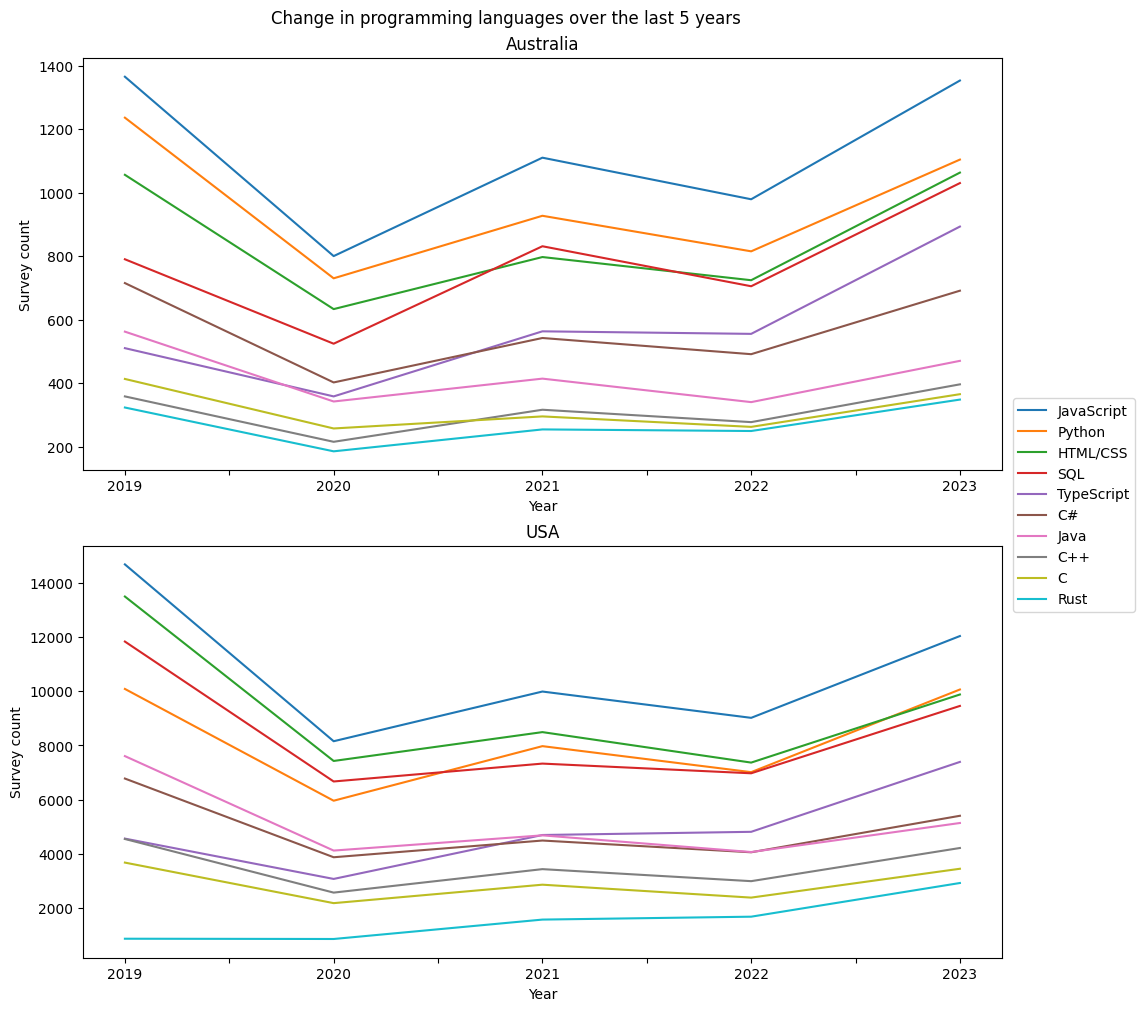

In [375]:
# Plot the data

fig, axes = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True)

df = df_10.copy()
df = df[df["Country"] == "Australia"].drop("Country", axis=1).set_index("LanguageHaveWorkedWith")
df = df.T

ax = df.plot.line(ax=axes[0])
ax.legend(loc="best")
ax.set_xlabel("Year")
ax.set_ylabel("Survey count")
ax.set_title("Australia")
ax.get_legend().remove()

df = df_10.copy()
df = df[df["Country"] == "USA"].drop("Country", axis=1).set_index("LanguageHaveWorkedWith")
df = df.T

ax = df.plot.line(ax=axes[1])
ax.legend(loc="best")
ax.set_xlabel("Year")
ax.set_ylabel("Survey count")
ax.set_title("USA")
ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Change in programming languages over the last 5 years")

plt.savefig("question3-1.png", bbox_inches='tight')
plt.show()


In [376]:

df_pivot["Growth%"] = (df_pivot[2023] - df_pivot[2019]) / df_pivot[2019] * 100
df_pivot = df_pivot.sort_values(by="Growth%", ascending=False)
df_20 = df_pivot[df_pivot["Growth%"] > 20]
print(df_20)

Year    Country LanguageHaveWorkedWith    2019    2020    2021    2022  \
44    Australia                   Rust    83.0    76.0   147.0   182.0   
99          USA                   Rust   879.0   869.0  1584.0  1691.0   
11    Australia                   Dart    32.0    29.0    56.0    65.0   
66          USA                   Dart   338.0   298.0   419.0   458.0   
50    Australia             TypeScript   510.0   358.0   563.0   555.0   
105         USA             TypeScript  4568.0  3082.0  4701.0  4818.0   
13    Australia                 Elixir    26.0     NaN    20.0    34.0   
26    Australia                 Kotlin    96.0    70.0   113.0    88.0   
19    Australia                     Go   189.0   118.0   148.0   165.0   
68          USA                 Elixir   406.0     NaN   399.0   414.0   
40    Australia                 Python   790.0   524.0   831.0   705.0   
14    Australia                 Erlang    15.0     NaN     6.0    10.0   
74          USA                     Go

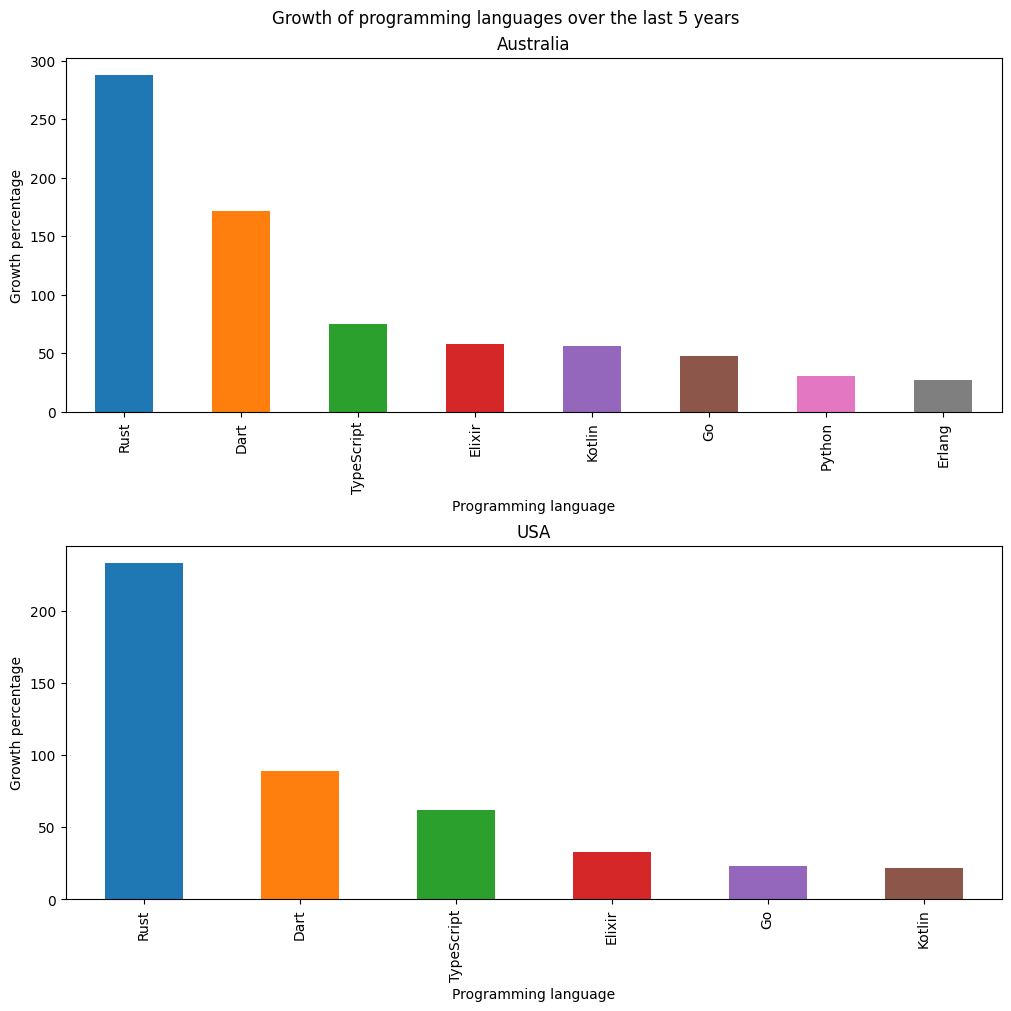

In [377]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig, axes = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True)

df = df_20.copy()
df = df[df["Country"] == "Australia"].drop("Country", axis=1).set_index("LanguageHaveWorkedWith")
df = df["Growth%"]

ax = df.plot.bar(ax=axes[0], color=colors)
#ax.bar(df["LanguageHaveWorkedWith"], df["Growth%"], color=colors)
ax.set_xlabel("Programming language")
ax.set_ylabel("Growth percentage")
ax.set_title("Australia")


df = df_20.copy()
df = df[df["Country"] == "USA"].drop("Country", axis=1).set_index("LanguageHaveWorkedWith")
df = df["Growth%"]

ax = df.plot.bar(ax=axes[1], color=colors)
#ax.bar(df["LanguageHaveWorkedWith"], df["Growth%"], color=colors)
ax.set_xlabel("Programming language")
ax.set_ylabel("Growth percentage")
ax.set_title("USA")

plt.suptitle("Growth of programming languages over the last 5 years")

plt.savefig("question3-2.png")
plt.show()